# Import Libraries

In [ ]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For modeling
import tensorflow as tf
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for hyperparameter tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load features and labels from train and val pickle

In [ ]:
with open('/content/drive/MyDrive/Projects/train_val_features_pkl/train_val_8_sec_audio_features_not_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [ ]:
audio_df

{'train': {'mfcc': array([[[0.2926833 , 0.5472208 , 0.51762646, ..., 0.42902297,
           0.5246572 , 0.39747417],
          [0.38219857, 0.63193434, 0.4692648 , ..., 0.4789598 ,
           0.5143834 , 0.35231233],
          [0.4352324 , 0.62795496, 0.4937711 , ..., 0.53823024,
           0.5205363 , 0.36665156],
          ...,
          [0.6295364 , 0.3740691 , 0.4684327 , ..., 0.74904454,
           0.6659465 , 0.13212648],
          [0.6729512 , 0.37194872, 0.47004578, ..., 0.63276273,
           0.6894711 , 0.25973636],
          [0.6984098 , 0.35604227, 0.50428545, ..., 0.49908003,
           0.694181  , 0.40737295]],
  
         [[0.571982  , 0.52721703, 0.35377806, ..., 0.31411108,
           0.45345846, 0.5325761 ],
          [0.57278824, 0.51283437, 0.33133256, ..., 0.44663262,
           0.59104645, 0.5540432 ],
          [0.5442881 , 0.50030595, 0.39622635, ..., 0.4177069 ,
           0.63780564, 0.5152073 ],
          ...,
          [0.65820706, 0.30996823, 0.5541669 , ..

In [ ]:
with open('/content/drive/MyDrive/Projects/train_val_features_pkl/train_val_8_sec_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

In [ ]:
non_audio_df

{'train': {'type': array(['blank', 'blank', 'blank', ..., 'blank', 'blank', 'blank'],
        dtype='<U5'),
  'continent': array(['AFRICA', 'AFRICA', 'AFRICA', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([5., 5., 5., ..., 5., 5., 5.]),
  'label': array([0, 0, 0, ..., 2, 2, 2])},
 'val': {'type': array(['song', 'call', 'call', ..., 'blank', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([3.5, 5. , 4. , ..., 5. , 3. , 3. ]),
  'label': array([0, 0, 1, ..., 2, 1, 2])}}

## confirm the audio features and non_audio features labels line-up

In [ ]:
assert np.array_equal(audio_df['train']['label'], non_audio_df['train']['label'])

In [ ]:
assert np.array_equal(audio_df['val']['label'], non_audio_df['val']['label'])

# Shuffle the data

In [ ]:
def shuffle_data(audio_features, non_audio_features):
  input_len = len(audio_features['label'])
  input_indices = np.random.permutation(input_len)
  audio_features = {key: np.array([audio_features[key][i] for i in input_indices]) for key in audio_features}
  non_audio_features = {key: np.array([non_audio_features[key][i] for i in input_indices]) for key in non_audio_features}

  return audio_features, non_audio_features

In [ ]:
audio_df['train'], non_audio_df['train'] = shuffle_data(audio_df['train'], non_audio_df['train'])

In [ ]:
for key in audio_df['train'].keys():
  display(key)
  display(audio_df['train'][key].shape)
  display(audio_df['train'][key][:5])

'mfcc'

(4763, 251, 20)

array([[[0.76562226, 0.42119646, 0.6317    , ..., 0.55656797,
         0.50043947, 0.5579883 ],
        [0.7701893 , 0.42523128, 0.587244  , ..., 0.60904306,
         0.52092993, 0.5788624 ],
        [0.7365245 , 0.4190816 , 0.609921  , ..., 0.5930985 ,
         0.5147305 , 0.6072767 ],
        ...,
        [0.7268985 , 0.42551512, 0.6471931 , ..., 0.42632353,
         0.58468026, 0.55358166],
        [0.7485684 , 0.4138609 , 0.64941096, ..., 0.38193256,
         0.49976096, 0.48085487],
        [0.75118613, 0.41563496, 0.61600816, ..., 0.3488722 ,
         0.5317388 , 0.3988245 ]],

       [[0.82813525, 0.7946115 , 0.33648843, ..., 0.37026787,
         0.30032092, 0.4022469 ],
        [0.8283402 , 0.7816895 , 0.33803236, ..., 0.49829328,
         0.39596698, 0.5079832 ],
        [0.7932821 , 0.73509586, 0.3926651 , ..., 0.57917625,
         0.46612298, 0.5084087 ],
        ...,
        [0.7578058 , 0.7628174 , 0.4437627 , ..., 0.42992026,
         0.48459285, 0.48570436],
        [0.7

'chroma'

(4763, 251, 12)

array([[[0.10272138, 0.19453515, 0.3259145 , ..., 0.25995663,
         0.11599457, 0.10125343],
        [0.568709  , 0.7053422 , 0.6774922 , ..., 0.6472096 ,
         0.31468916, 0.34499285],
        [0.72204584, 1.0000001 , 0.81097794, ..., 0.33884162,
         0.17562923, 0.28373325],
        ...,
        [0.48914686, 0.57848495, 0.8552232 , ..., 0.91095906,
         0.95416105, 0.5701492 ],
        [0.19276999, 0.17570825, 0.23244847, ..., 0.7494074 ,
         1.0000001 , 0.5434211 ],
        [0.16483103, 0.12467781, 0.11018404, ..., 0.5688802 ,
         0.9196118 , 0.52621025]],

       [[0.6310996 , 0.6724936 , 0.814979  , ..., 0.7324207 ,
         0.68329585, 0.99999994],
        [0.5494648 , 0.702685  , 0.9601639 , ..., 0.9954234 ,
         0.87284815, 1.        ],
        [0.515053  , 0.7047445 , 1.        , ..., 0.8705612 ,
         0.82521755, 0.80517197],
        ...,
        [0.69953626, 0.6407776 , 0.5759708 , ..., 0.8233199 ,
         1.        , 0.98831934],
        [0.6

'rms'

(4763, 251, 1)

array([[[0.04967979],
        [0.05153614],
        [0.05180881],
        ...,
        [0.07758229],
        [0.08070631],
        [0.07605864]],

       [[0.04498956],
        [0.04948206],
        [0.05258569],
        ...,
        [0.04009759],
        [0.03663244],
        [0.02982151]],

       [[0.02523206],
        [0.03012922],
        [0.03312536],
        ...,
        [0.02631574],
        [0.02233782],
        [0.01838951]],

       [[0.01899461],
        [0.02049237],
        [0.02218727],
        ...,
        [0.0190062 ],
        [0.01783613],
        [0.01485544]],

       [[0.00221086],
        [0.00270604],
        [0.00322055],
        ...,
        [0.02603236],
        [0.02618032],
        [0.0261768 ]]], dtype=float32)

'spectral_centroid'

(4763, 251, 1)

array([[[0.70441395],
        [0.69578758],
        [0.7147997 ],
        ...,
        [0.57551465],
        [0.57324656],
        [0.53850231]],

       [[0.20972907],
        [0.21095609],
        [0.22838129],
        ...,
        [0.21339519],
        [0.22138565],
        [0.2240087 ]],

       [[0.26801692],
        [0.27611027],
        [0.29145989],
        ...,
        [0.29161986],
        [0.28269786],
        [0.27796374]],

       [[0.17662125],
        [0.16379993],
        [0.14698778],
        ...,
        [0.09182787],
        [0.08973193],
        [0.08084867]],

       [[0.52749824],
        [0.52686609],
        [0.54880041],
        ...,
        [0.47378894],
        [0.47684068],
        [0.48934326]]])

'melspectrogram'

(4763, 251, 20)

array([[[0.6336223 , 0.607534  , 0.52183425, ..., 0.7395594 ,
         0.71257347, 0.7245784 ],
        [0.6416759 , 0.5927018 , 0.54583883, ..., 0.71506816,
         0.72566456, 0.7355503 ],
        [0.6323266 , 0.596973  , 0.54292274, ..., 0.7233468 ,
         0.71351594, 0.7502541 ],
        ...,
        [0.68736386, 0.66078293, 0.6093227 , ..., 0.7416815 ,
         0.70024794, 0.58101046],
        [0.675395  , 0.66949415, 0.60750884, ..., 0.7269534 ,
         0.7333857 , 0.6151837 ],
        [0.67633516, 0.6558848 , 0.5924165 , ..., 0.6753149 ,
         0.70193326, 0.5675263 ]],

       [[0.7504628 , 0.7835923 , 0.75879747, ..., 0.51513743,
         0.4321084 , 0.42541638],
        [0.7477904 , 0.7927896 , 0.7754527 , ..., 0.51328146,
         0.44127676, 0.4091469 ],
        [0.7433172 , 0.8022345 , 0.7596235 , ..., 0.52656335,
         0.4463729 , 0.42617437],
        ...,
        [0.7870468 , 0.7767747 , 0.7771366 , ..., 0.49148917,
         0.4256444 , 0.38380376],
        [0.7

'label'

(4763,)

array([0, 1, 1, 1, 0])

In [ ]:
for key in non_audio_df['train'].keys():
  display(key)
  display(non_audio_df['train'][key].shape)
  display(non_audio_df['train'][key][:5])

'type'

(4763,)

array(['song', 'call', 'call', 'call', 'song'], dtype='<U5')

'continent'

(4763,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'EUROPE', 'AMERICAS'], dtype='<U8')

'rating'

(4763,)

array([4.5, 4. , 4. , 3. , 4.5])

'label'

(4763,)

array([0, 1, 1, 1, 0])

In [ ]:
audio_df['val'], non_audio_df['val'] = shuffle_data(audio_df['val'], non_audio_df['val'])

In [ ]:
for key in audio_df['val'].keys():
  display(key)
  display(audio_df['val'][key].shape)
  display(audio_df['val'][key][:5])

'mfcc'

(2430, 251, 20)

array([[[0.52893126, 0.26861447, 0.4803219 , ..., 0.52772367,
         0.4431101 , 0.54016894],
        [0.50701123, 0.2520212 , 0.4139939 , ..., 0.5866404 ,
         0.5000729 , 0.5751083 ],
        [0.47890854, 0.2499012 , 0.45414388, ..., 0.63691396,
         0.52460426, 0.49441603],
        ...,
        [0.46749723, 0.26022968, 0.5166426 , ..., 0.48705894,
         0.5392216 , 0.4672047 ],
        [0.49123222, 0.30467737, 0.5443408 , ..., 0.46905434,
         0.49625874, 0.4559087 ],
        [0.5254533 , 0.3169461 , 0.58261365, ..., 0.42800897,
         0.57285863, 0.46917748]],

       [[0.08390749, 0.54681754, 0.516134  , ..., 0.43573105,
         0.5225513 , 0.39742553],
        [0.30008537, 0.63215584, 0.40367687, ..., 0.47399116,
         0.48719335, 0.44505128],
        [0.5058722 , 0.6067998 , 0.45201087, ..., 0.4935217 ,
         0.5343093 , 0.48605922],
        ...,
        [0.5736662 , 0.6491879 , 0.48376167, ..., 0.5008712 ,
         0.6287025 , 0.2632634 ],
        [0.5

'chroma'

(2430, 251, 12)

array([[[0.399859  , 0.8783467 , 1.        , ..., 0.1435743 ,
         0.09723334, 0.18516995],
        [0.35672295, 0.61267096, 1.        , ..., 0.14863217,
         0.11991244, 0.14763726],
        [0.36814234, 0.5166141 , 1.        , ..., 0.12212875,
         0.09047797, 0.09694317],
        ...,
        [0.38559076, 0.70545375, 0.92514193, ..., 0.10453992,
         0.10710306, 0.13166143],
        [0.31648707, 0.6787172 , 0.92246264, ..., 0.14788078,
         0.17655939, 0.16442937],
        [0.40044928, 0.9360577 , 1.0000001 , ..., 0.24675849,
         0.315252  , 0.34775564]],

       [[0.6723946 , 0.6142802 , 0.5424889 , ..., 0.81971174,
         0.6639928 , 0.6211325 ],
        [0.343638  , 0.35003704, 0.8353582 , ..., 0.33108592,
         0.17352998, 0.16693738],
        [0.49474594, 0.7664114 , 0.76002043, ..., 0.38975635,
         0.47422424, 0.41882303],
        ...,
        [0.68234676, 1.        , 0.21909957, ..., 0.16791008,
         0.1547872 , 0.23108214],
        [0.3

'rms'

(2430, 251, 1)

array([[[8.30594916e-03],
        [9.52370279e-03],
        [1.03560193e-02],
        ...,
        [1.03261229e-02],
        [9.16901883e-03],
        [7.30404444e-03]],

       [[1.10220462e-05],
        [2.29988853e-03],
        [3.57564609e-03],
        ...,
        [8.08642991e-03],
        [7.67003465e-03],
        [6.37321686e-03]],

       [[3.77655705e-03],
        [4.34118882e-03],
        [4.61205142e-03],
        ...,
        [4.75192349e-03],
        [4.30035498e-03],
        [3.49946320e-03]],

       [[1.13588516e-02],
        [1.09681925e-02],
        [1.06127756e-02],
        ...,
        [1.09228389e-02],
        [1.02904085e-02],
        [8.34590197e-03]],

       [[4.33451086e-02],
        [5.23377396e-02],
        [5.64512499e-02],
        ...,
        [2.15665046e-02],
        [2.06167568e-02],
        [1.65463407e-02]]], dtype=float32)

'spectral_centroid'

(2430, 251, 1)

array([[[0.65708921],
        [0.64941984],
        [0.6723296 ],
        ...,
        [0.65399054],
        [0.65508474],
        [0.64994206]],

       [[0.54292909],
        [0.36807527],
        [0.37962919],
        ...,
        [0.31682838],
        [0.32980329],
        [0.34429498]],

       [[0.4991495 ],
        [0.49604094],
        [0.50973498],
        ...,
        [0.4724821 ],
        [0.48155052],
        [0.47162446]],

       [[0.21099564],
        [0.23744904],
        [0.28400392],
        ...,
        [0.22189986],
        [0.208646  ],
        [0.18768472]],

       [[0.19128688],
        [0.17977766],
        [0.17590037],
        ...,
        [0.34849218],
        [0.27114406],
        [0.28991484]]])

'melspectrogram'

(2430, 251, 20)

array([[[0.32507434, 0.30990273, 0.29362816, ..., 0.58076465,
         0.5385883 , 0.51950634],
        [0.30098525, 0.23049897, 0.2492401 , ..., 0.57880485,
         0.5430559 , 0.503304  ],
        [0.29913336, 0.22474879, 0.22421515, ..., 0.597378  ,
         0.5449969 , 0.51883745],
        ...,
        [0.3539606 , 0.25720108, 0.20510101, ..., 0.5808016 ,
         0.5474135 , 0.50684214],
        [0.3486237 , 0.2808447 , 0.26874763, ..., 0.5575399 ,
         0.5637771 , 0.5085467 ],
        [0.3939511 , 0.3350249 , 0.32836175, ..., 0.5436782 ,
         0.56710935, 0.4945698 ]],

       [[0.13149762, 0.07773644, 0.05920345, ..., 0.02387589,
         0.01296973, 0.03129351],
        [0.31631216, 0.2691881 , 0.2695461 , ..., 0.16528893,
         0.1698237 , 0.17259336],
        [0.4591149 , 0.49076372, 0.47587875, ..., 0.35676712,
         0.34386635, 0.3576033 ],
        ...,
        [0.544253  , 0.59059167, 0.6302319 , ..., 0.37573183,
         0.39077306, 0.40557453],
        [0.5

'label'

(2430,)

array([0, 2, 2, 0, 0])

In [ ]:
for key in non_audio_df['val'].keys():
  display(key)
  display(non_audio_df['val'][key].shape)
  display(non_audio_df['val'][key][:5])

'type'

(2430,)

array(['both', 'call', 'song', 'song', 'song'], dtype='<U5')

'continent'

(2430,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'UNKNOWN', 'EUROPE'], dtype='<U8')

'rating'

(2430,)

array([5. , 3.5, 5. , 3. , 1. ])

'label'

(2430,)

array([0, 2, 2, 0, 0])

# Create sample weights based on rating

In [ ]:
training_sample_weights = non_audio_df['train']['rating']

training_sample_weights

array([4.5, 4. , 4. , ..., 4. , 3. , 4.5])

In [ ]:
validation_sample_weights = non_audio_df['val']['rating']

validation_sample_weights

array([5. , 3.5, 5. , ..., 3. , 3. , 4. ])

In [ ]:
training_sample_weights = np.where(training_sample_weights > 3.0, 0.6, 0.4)

training_sample_weights

array([0.6, 0.6, 0.6, ..., 0.6, 0.4, 0.6])

In [ ]:
validation_sample_weights = np.where(validation_sample_weights > 3.0, 0.6, 0.4)

validation_sample_weights

array([0.6, 0.6, 0.6, ..., 0.4, 0.4, 0.6])

# 1D CNN Models

In [ ]:
train_results = {}
val_results = {}

In [ ]:
classes = ['barswa', 'comsan', 'eaywag1']

## Create visualization function

In [ ]:
def visualize(model_history, best_epoch):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  # visualize the loss
  axes[0].plot(model_history.history['loss'][:best_epoch+1], color='purple', label='train_losses')
  axes[0].plot(model_history.history['val_loss'][:best_epoch+1], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  # visualze the accuracy
  axes[1].plot(model_history.history['accuracy'][:best_epoch+1], color='purple', label='train_accuracy')
  axes[1].plot(model_history.history['val_accuracy'][:best_epoch+1], color='orange', label='val_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy Progression')
  axes[1].legend()

  plt.show()

In [ ]:
np.unique(non_audio_df['train']['continent'])

array(['AFRICA', 'AMERICAS', 'ASIA', 'EUROPE', 'UNKNOWN'], dtype='<U8')

## With mfcc & rms & spectral_centroid & continents

### create features

In [ ]:
training_audio_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=-1)

training_audio_features

array([[[0.76562226, 0.42119646, 0.63169998, ..., 0.55798829,
         0.04967979, 0.70441395],
        [0.77018929, 0.42523128, 0.58724397, ..., 0.57886243,
         0.05153614, 0.69578758],
        [0.73652452, 0.4190816 , 0.60992098, ..., 0.60727668,
         0.05180881, 0.7147997 ],
        ...,
        [0.72689849, 0.42551512, 0.64719307, ..., 0.55358166,
         0.07758229, 0.57551465],
        [0.74856842, 0.41386089, 0.64941096, ..., 0.48085487,
         0.08070631, 0.57324656],
        [0.75118613, 0.41563496, 0.61600816, ..., 0.39882451,
         0.07605864, 0.53850231]],

       [[0.82813525, 0.79461151, 0.33648843, ..., 0.40224689,
         0.04498956, 0.20972907],
        [0.82834017, 0.78168952, 0.33803236, ..., 0.50798321,
         0.04948206, 0.21095609],
        [0.79328209, 0.73509586, 0.39266509, ..., 0.50840873,
         0.05258569, 0.22838129],
        ...,
        [0.75780582, 0.76281738, 0.44376269, ..., 0.48570436,
         0.04009759, 0.21339519],
        [0.7

In [ ]:
training_audio_features.shape

(4763, 251, 22)

In [ ]:
validation_audio_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=-1)

validation_audio_features

array([[[5.28931260e-01, 2.68614471e-01, 4.80321914e-01, ...,
         5.40168941e-01, 8.30594916e-03, 6.57089206e-01],
        [5.07011235e-01, 2.52021194e-01, 4.13993895e-01, ...,
         5.75108290e-01, 9.52370279e-03, 6.49419840e-01],
        [4.78908539e-01, 2.49901205e-01, 4.54143882e-01, ...,
         4.94416028e-01, 1.03560193e-02, 6.72329600e-01],
        ...,
        [4.67497230e-01, 2.60229677e-01, 5.16642570e-01, ...,
         4.67204690e-01, 1.03261229e-02, 6.53990540e-01],
        [4.91232216e-01, 3.04677367e-01, 5.44340789e-01, ...,
         4.55908686e-01, 9.16901883e-03, 6.55084736e-01],
        [5.25453329e-01, 3.16946089e-01, 5.82613647e-01, ...,
         4.69177485e-01, 7.30404444e-03, 6.49942061e-01]],

       [[8.39074850e-02, 5.46817541e-01, 5.16134024e-01, ...,
         3.97425532e-01, 1.10220462e-05, 5.42929088e-01],
        [3.00085366e-01, 6.32155836e-01, 4.03676867e-01, ...,
         4.45051283e-01, 2.29988853e-03, 3.68075266e-01],
        [5.05872190e-01, 

In [ ]:
validation_audio_features.shape

(2430, 251, 22)

### use hyperopt to find the best parameters

In [42]:
space = {'learning_rate': hp.uniform('learning_rate',0.0005,0.005),
         'layers': hp.choice('layers',[2,3]),
         'filter_1': hp.choice('filter_1', [64, 128, 256]),
         'filter_2': hp.choice('filter_2', [32, 64]),
         'filter_3': hp.choice('filter_3', [8, 16]),
         'kernel_1': hp.choice('kernel_1', [4,5,6]),
         'kernel_2': hp.choice('kernel_2', [3,4,5]),
         'kernel_3': hp.choice('kernel_3', [2,3,4]),
         'stride_1': hp.choice('stride_1', [1,2]),
         'stride_2': hp.choice('stride_2', [1,2]),
         'stride_3': hp.choice('stride_3', [1,2]),
         'reg_strength': hp.uniform('reg_strength',0.01,0.03),
         'pool_1': hp.choice('pool_1', [2,3]),
         'pool_2': hp.choice('pool_2', [2,3]),
         'pool_3': hp.choice('pool_3', [2,3]),
         'dropout': hp.uniform('dropout',0.1,0.5),
         'dense': hp.choice('dense', [512,1024,2048]),
         'batch_size': hp.choice('batch_size', [8,16,32])
          }

In [ ]:
def cnn_model(params):

  audio_features = training_audio_features
  continent_feature = non_audio_df['train']['continent']

  tf.keras.backend.clear_session()

  # set audio features input layer
  audio_features = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')

  # set continent features input layer
  location = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Continents')
  location_binned = tf.keras.layers.StringLookup(vocabulary=np.unique(continent_feature))(location)
  location_embed = tf.keras.layers.Embedding(input_dim=(len(np.unique(continent_feature))+1), output_dim=2, input_length=1)(location_binned)

  # custom function to tile the 'Location' embeddings to match the time steps of audio features
  def tile_location_embed(x):
      return tf.keras.backend.tile(x, [1, audio_features.shape[1], 1])

  # using the Lambda layer with the custom function
  location_embed = tf.keras.layers.Lambda(tile_location_embed, name='Tile')(location_embed)

  # create features using both continents with embeddings and mfccs
  features = tf.keras.layers.Concatenate(axis=2, name='Features')([location_embed, audio_features])

  # get the hyperparameters from params
  learning_rate = params['learning_rate']     #learning_rate = 0.001
  n_layers = params['layers']                 #n_layers = 3
  dropout = params['dropout']                 #dropout = 0.1
  dense = params['dense']                     #dense = 1024
  batch_size = params['batch_size']           #batch_size = 32

  for i in range(1, n_layers+1):      #3
    # add convolution layer to the model
    filter = f'filter_{i}'
    kernel = f'kernel_{i}'
    stride = f'stride_{i}'
    pool = f'pool_{i}'
    features = tf.keras.layers.Conv1D(
                filters=params[filter],           #32
                kernel_size=params[kernel],       #5
                strides=params[stride],           #1
                padding='same',
                data_format='channels_last',
                name=f'conv_{i}',
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(params['reg_strength']))(features) #0.02

    # add max pooling layer
    features = tf.keras.layers.MaxPool1D(pool_size=params[pool], name=f'pool_{i}')(features) #2

    # add dropout layer
    features = tf.keras.layers.Dropout(rate=dropout)(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=dense,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=dropout)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities but
  # in TensorFlow logits are prefered for numerical stability
  # set units=3 to get a 3 output unit (remember it's 3 species)
  outputs = tf.keras.layers.Dense(
      units=3,
      name='fc_2',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[location, audio_features],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply softmax
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  # define callback
  callback = tf.keras.callbacks.EarlyStopping(monitor="val_weighted_accuracy",
                                              patience=10,
                                              restore_best_weights=True,
                                              start_from_epoch=20
                                              )

  # fit model
  history = model.fit(
    x={
        'Continents': non_audio_df['train']['continent'],
        'Audio_Features': training_audio_features
    },
    y=audio_df['train']['label'],
    sample_weight=training_sample_weights,
    epochs=40,
    validation_data=(
        {
        'Continents': non_audio_df['val']['continent'],
        'Audio_Features': validation_audio_features
    },
        audio_df['val']['label'],
        validation_sample_weights
    ),
    batch_size=batch_size,
    callbacks=[callback],
    verbose=0)

  best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
  best_accuracy = np.amax(history.history['val_weighted_accuracy'])
  validation_loss = np.amin(history.history['val_loss'])

  print('best_epoch: ', best_epoch)
  print('best_accuracy: ', best_accuracy)

  return {'loss': validation_loss,
          'status': STATUS_OK,
          'params': params}

In [43]:
trials = Trials()
best = fmin(cnn_model, space, algo=tpe.suggest, max_evals=50, trials=trials)

Model: "Birds"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 Continents (InputLayer)     [(None, 1)]                  0         []                            

 string_lookup (StringLooku  (None, 1)                    0         ['Continents[0][0]']          

 p)                                                                                               

 embedding (Embedding)       (None, 1, 2)                 12        ['string_lookup[0][0]']       

 Tile (Lambda)               (None, 251, 2)               0         ['embedding[0][0]']           

 Audio_Features (InputLayer  [(None, 251, 22)]            0         []                            

 )                                                                                                

 Features (Concatenate)      (None, 251, 24)              0         ['Tile[0][0]', 

In [44]:
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
best_params

{'batch_size': 16,
 'dense': 1024,
 'dropout': 0.16943665861885554,
 'filter_1': 256,
 'filter_2': 32,
 'filter_3': 16,
 'kernel_1': 4,
 'kernel_2': 4,
 'kernel_3': 4,
 'layers': 2,
 'learning_rate': 0.0005263041657540712,
 'pool_1': 3,
 'pool_2': 3,
 'pool_3': 2,
 'pool_4': 2,
 'reg_strength': 0.028837227046363417,
 'stride_1': 2,
 'stride_2': 2,
 'stride_3': 1}

In [48]:
# params
learning_rate = round(best_params['learning_rate'],5)
n_layers = best_params['layers']
filters = [best_params['filter_1'], best_params['filter_2']]
kernels = [best_params['kernel_1'], best_params['kernel_2']]
strides = [best_params['stride_1'], best_params['stride_2']]
reg = round(best_params['reg_strength'],2)
pools = [best_params['pool_1'], best_params['pool_2']]
dropout = round(best_params['dropout'],2)
dense = best_params['dense']
batch_size = best_params['batch_size']

## train the model using the best parameters found using hyperopt

In [46]:
def build_model(audio_features,
                continent_feature,
                learning_rate=learning_rate):

  tf.keras.backend.clear_session()

  # set audio features input layer
  audio_features = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')

  # set continent features input layer
  location = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Continents')
  location_binned = tf.keras.layers.StringLookup(vocabulary=np.unique(continent_feature))(location)
  location_embed = tf.keras.layers.Embedding(input_dim=(len(np.unique(continent_feature))+1), output_dim=2, input_length=1)(location_binned)

  # custom function to tile the 'Location' embeddings to match the time steps of audio features
  def tile_location_embed(x):
      return tf.keras.backend.tile(x, [1, audio_features.shape[1], 1])

  # using the Lambda layer with the custom function
  location_embed = tf.keras.layers.Lambda(tile_location_embed, name='Tile')(location_embed)

  # create features using both continents with embeddings and mfccs
  features = tf.keras.layers.Concatenate(axis=2, name='Features')([location_embed, audio_features])

  for i in range(n_layers):
    # add convolution layer to the model
    features = tf.keras.layers.Conv1D(
                filters=filters[i],
                kernel_size=kernels[i],
                strides=strides[i],
                padding='same',
                data_format='channels_last',
                name=f'conv_{i}',
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(reg))(features)

    # add max pooling layer
    features = tf.keras.layers.MaxPool1D(pool_size=pools[i], name=f'pool_{i}')(features)

    # add dropout layer
    features = tf.keras.layers.Dropout(rate=dropout)(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=dense,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=dropout)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities but
  # in TensorFlow logits are prefered for numerical stability
  # set units=3 to get a 3 output unit (remember it's 3 species)
  outputs = tf.keras.layers.Dense(
      units=3,
      name='fc_2',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[location, audio_features],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply softmax
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [47]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_weighted_accuracy",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=20,
)

Model: "Birds"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Continents (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 string_lookup (StringLooku  (None, 1)                    0         ['Continents[0][0]']          
 p)                                                                                               
                                                                                                  
 embedding (Embedding)       (None, 1, 2)                 12        ['string_lookup[0][0]']       
                                                                                                  
 Tile (Lambda)               (None, 251, 2)               0         ['embedding[0][0]']       

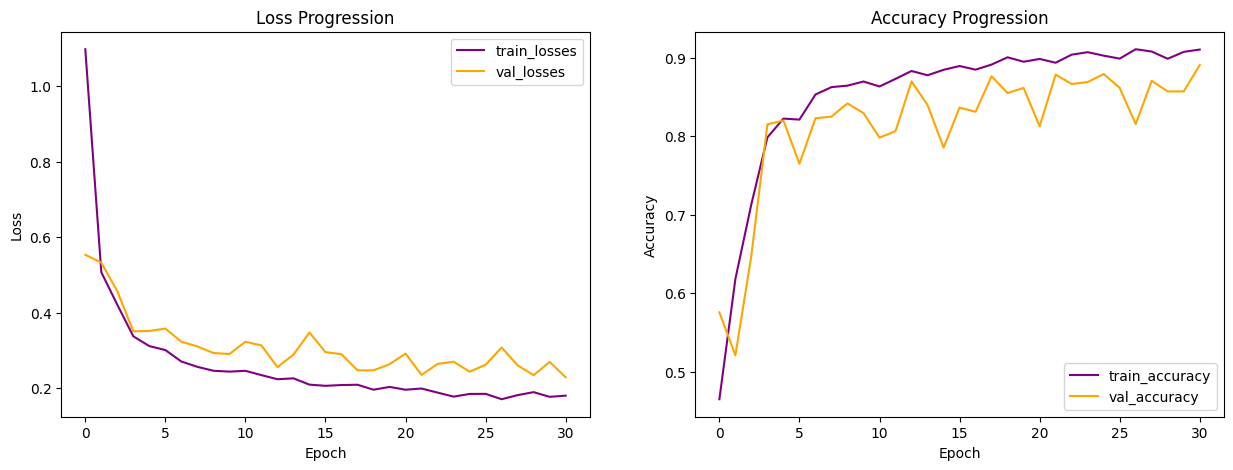

In [50]:
model = build_model(training_audio_features,
                    non_audio_df['train']['continent'])

history = model.fit(
   x={
      'Continents': non_audio_df['train']['continent'],
      'Audio_Features': training_audio_features
   },
   y=audio_df['train']['label'],
   sample_weight=training_sample_weights,
   epochs=100,
   validation_data=(
      {
      'Continents': non_audio_df['val']['continent'],
      'Audio_Features': validation_audio_features
   },
      audio_df['val']['label'],
      validation_sample_weights
   ),
   batch_size=batch_size,
   callbacks=[callback],
   verbose=1)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)

visualize(history, best_epoch)

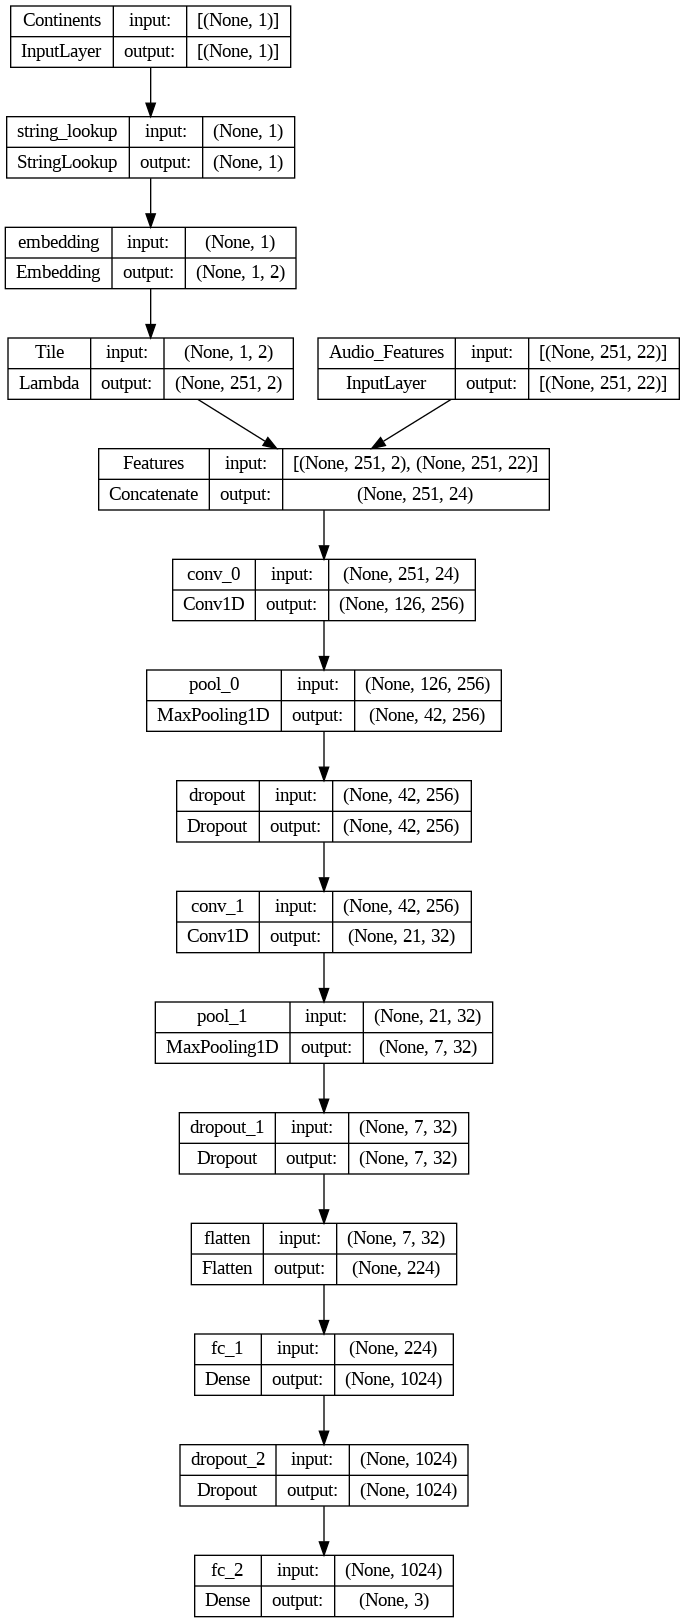

In [51]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [52]:
train_yhat = model.predict({'Continents': non_audio_df['train']['continent'],
                            'Audio_Features': training_audio_features
                            })

train_yhat_result = np.argmax(train_yhat, axis=-1)

train_results['mfcc_rms_spectral_centroid_continents'] = model.evaluate({'Continents': non_audio_df['train']['continent'],
                                                          'Audio_Features': training_audio_features},
                                                         audio_df['train']['label'])[-1]

149/149 [==============================] - 1s 6ms/step - loss: 0.2302 - accuracy: 0.9400 - weighted_accuracy: 0.9400


In [53]:
val_yhat = model.predict({'Continents': non_audio_df['val']['continent'],
                          'Audio_Features': validation_audio_features
                          })

val_yhat_result = np.argmax(val_yhat, axis=-1)

val_results['mfcc_rms_spectral_centroid_continents'] = model.evaluate({'Continents': non_audio_df['val']['continent'],
                                                          'Audio_Features': validation_audio_features},
                                                         audio_df['val']['label'])[-1]

76/76 [==============================] - 0s 6ms/step - loss: 0.3955 - accuracy: 0.8909 - weighted_accuracy: 0.8909


### evaluate the results

In [54]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.94      0.93      0.93      1603
      comsan       0.94      0.96      0.95      1578
     eaywag1       0.94      0.93      0.93      1582

    accuracy                           0.94      4763
   macro avg       0.94      0.94      0.94      4763
weighted avg       0.94      0.94      0.94      4763



In [55]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.90      0.88      0.89      1032
      comsan       0.86      0.91      0.88       618
     eaywag1       0.91      0.90      0.90       780

    accuracy                           0.89      2430
   macro avg       0.89      0.89      0.89      2430
weighted avg       0.89      0.89      0.89      2430



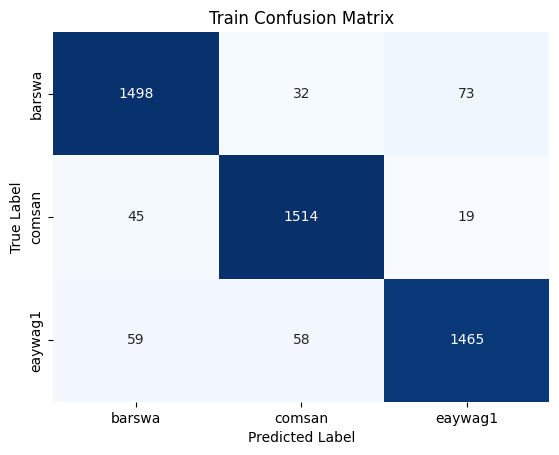

In [56]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

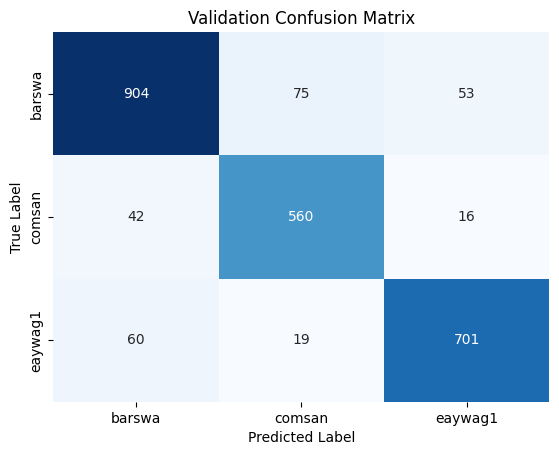

In [57]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

# Review results from all models

In [58]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Val_Accuracy')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,mfcc_rms_spectral_centroid_continents,0.94,0.89
